#Setup

In [1]:
%pip install h3

from google.colab import files
import json
import re

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import h3

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import RadiusNeighborsRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.0 MB/s eta 0:00:00


# Load Data

In [2]:
# Load apartments csv and zone borders geojson.
# Geojson available at https://sig.muniguate.com/tmp/rest/services/Mapas_base/zonas/MapServer/0/query.
_ = files.upload()

Saving citymap_apartments_20250318.csv to citymap_apartments_20250318.csv
Saving zones.json to zones.json


In [3]:
df = pd.read_csv('citymap_apartments_20250318.csv')\
  .drop_duplicates(ignore_index=True)

zone_borders = gpd.read_file('zones.json')

In [4]:
df.head()

,Metraje,Cantidad de habitaciones,Baños,apartment_type,project_name,project_url,project_description,project_c_time,project_m_time,project_img_url,project_zone,project_status,project_lat,project_lon,Parqueos,Cuotas desde,Precio desde,Incluye bodega,Incluye área de servicio
0,66.2m²,1,1,Tipo C,park-palace,https://citymap.com.gt/propiedades/park-palace/,"Ubicados en Zona 15. Con apartamentos de 1, 2 ...",2025-02-28T16:29:28+00:00,2025-02-28T16:42:42+00:00,https://citymap.com.gt/wp-content/uploads/2025...,zona-15,Null,14.589525,-90.487003,NaN,NaN,NaN,NaN,NaN
1,102.15m²,1,1.5,Tipo E,park-palace,https://citymap.com.gt/propiedades/park-palace/,"Ubicados en Zona 15. Con apartamentos de 1, 2 ...",2025-02-28T16:29:28+00:00,2025-02-28T16:42:42+00:00,https://citymap.com.gt/wp-content/uploads/2025...,zona-15,Null,14.589525,-90.487003,NaN,NaN,NaN,NaN,NaN
2,104.22m²,1,1.5,Tipo F,park-palace,https://citymap.com.gt/propiedades/park-palace/,"Ubicados en Zona 15. Con apartamentos de 1, 2 ...",2025-02-28T16:29:28+00:00,2025-02-28T16:42:42+00:00,https://citymap.com.gt/wp-content/uploads/2025...,zona-15,Null,14.589525,-90.487003,NaN,NaN,NaN,NaN,NaN
3,71.38m²,1,1,Tipo G,park-palace,https://citymap.com.gt/propiedades/park-palace/,"Ubicados en Zona 15. Con apartamentos de 1, 2 ...",2025-02-28T16:29:28+00:00,2025-02-28T16:42:42+00:00,https://citymap.com.gt/wp-content/uploads/2025...,zona-15,Null,14.589525,-90.487003,NaN,NaN,NaN,NaN,NaN
4,103.65m²,2,2,Tipo B,park-palace,https://citymap.com.gt/propiedades/park-palace/,"Ubicados en Zona 15. Con apartamentos de 1, 2 ...",2025-02-28T16:29:28+00:00,2025-02-28T16:42:42+00:00,https://citymap.com.gt/wp-content/uploads/2025...,zona-15,Null,14.589525,-90.487003,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Metraje                   1764 non-null   object 
 1   Cantidad de habitaciones  1880 non-null   object 
 2   Baños                     1874 non-null   object 
 3   apartment_type            1880 non-null   object 
 4   project_name              1880 non-null   object 
 5   project_url               1880 non-null   object 
 6   project_description       1880 non-null   object 
 7   project_c_time            1880 non-null   object 
 8   project_m_time            1880 non-null   object 
 9   project_img_url           1880 non-null   object 
 10  project_zone              1880 non-null   object 
 11  project_status            1880 non-null   object 
 12  project_lat               1880 non-null   float64
 13  project_lon               1880 non-null   float64
 14  Parqueos

In [6]:
df.describe(include='all')

,Metraje,Cantidad de habitaciones,Baños,apartment_type,project_name,project_url,project_description,project_c_time,project_m_time,project_img_url,project_zone,project_status,project_lat,project_lon,Parqueos,Cuotas desde,Precio desde,Incluye bodega,Incluye área de servicio
count,1764,1880,1874,1880,1880,1880,1880,1880,1880,1880,1880,1880,1880.000000,1880.000000,1247,174,238,183,288
unique,897,9,14,1066,344,344,344,344,343,344,30,5,NaN,NaN,15,146,209,1,1
top,70m²,3,2,A,baden,https://citymap.com.gt/propiedades/baden/,"Ubicados en Zona 15. Con apartamentos de 1, 2 ...",2020-11-05T19:15:26+00:00,2024-12-13T18:01:29+00:00,https://citymap.com.gt/wp-content/uploads/2020...,zona-10,Null,NaN,NaN,2,"Q4,600","$119,000",Si,Si
freq,25,820,810,52,33,33,33,33,33,33,346,1085,NaN,NaN,761,4,4,183,288
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.599890,-90.161459,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028510,6.235062,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.482234,-90.671859,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.585637,-90.525255,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.594127,-90.511054,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.610104,-90.494984,NaN,NaN,NaN,NaN,NaN


In [7]:
# In df, (project_name, apartment_type) is almost unique, but some apartments
# of the "same" apartment type have slight variations.
print('Number of unique apartment projects:',
 len(df.value_counts(['project_name'])))
print('Number of unique apartment types:',
 len(df.value_counts(['project_name', 'apartment_type'])))

Number of unique apartment projects: 344
Number of unique apartment types: 1835


# Preprocessing

In [8]:
# Replace a wrong value at a given apartment.
def clean_value(df, project_name, apartment_type, var, old_val, new_val):
  index = (df['project_name'] == project_name) \
    & (df['apartment_type'] == apartment_type)
  index &= (df[var] == old_val) if old_val else df[var].isna()
  assert index.sum() == 1
  df.loc[index, var] = new_val

In [9]:
# Rename and reorder columns.
new_columns = {
  'Metraje': 'apartment_m2',
  'Cantidad de habitaciones': 'apartment_beds',
  'Baños': 'apartment_baths',
  'Parqueos': 'apartment_parking',
  'Incluye área de servicio': 'apartment_has_serviceroom',
  'Incluye bodega': 'apartment_has_storeroom',
  'Cuotas desde': 'apartment_rent',
  'Precio desde': 'apartment_price',
}
column_order = [
  'project_name', 'apartment_type', 'project_url', 'project_description',
  'project_c_time', 'project_m_time', 'project_img_url', 'project_zone',
  'project_status', 'project_lat', 'project_lon', 'apartment_m2',
  'apartment_beds', 'apartment_baths', 'apartment_parking',
  'apartment_has_serviceroom', 'apartment_has_storeroom',
  'apartment_rent', 'apartment_price'
]
df = df.rename(columns=new_columns)[column_order]

# Process creation and modification dates.
df['project_c_date'] = pd.to_datetime(df['project_c_time']).dt.date
df['project_m_date'] = pd.to_datetime(df['project_m_time']).dt.date
df = df.drop(columns=['project_c_time', 'project_m_time'])

# Process status.
df.replace({'project_status': {'Null': None}}, inplace=True)

# Correct locations.
df.loc[df['project_name'] == 'vidalta', 'project_lon'] = -90.55304

# Process apartment footage in meters squared.
df['apartment_m2'] = df['apartment_m2']\
  .str.extract('([\d.,]+)m²')\
  .astype(float)

# Correct and process number of beds, baths and parking spots.
clean_value(df, 'via-pulte', 'Apto C702', 'apartment_baths', '33.5', np.nan)
clean_value(df, 'essenza-apartamentos', 'Tipo F', 'apartment_parking', '12', np.nan)

df['apartment_beds'] = pd.to_numeric(df['apartment_beds'], errors='coerce')
df['apartment_baths'] = pd.to_numeric(df['apartment_baths'], errors='coerce')
df['apartment_parking'] = pd.to_numeric(df['apartment_parking'], errors='coerce')
df.replace({'apartment_has_serviceroom': {'Si': True}}, inplace=True)
df.replace({'apartment_has_storeroom': {'Si': True}}, inplace=True)

# Correct and process rent and price in dollars.
clean_value(df, 'villa-isabel', 'Tipo E', 'apartment_rent', 'Q5.812', 'Q5,812')
clean_value(df, 'piera-ciudad-vieja', '2H', 'apartment_rent', 'Q1,750,000', 'Q8,950')
clean_value(df, 'piera-ciudad-vieja', '2H', 'apartment_price', 'Q8,950', 'Q1,750,000')
clean_value(df, 'vicinia-las-americas',	'Vicinia Bold', 'apartment_price', 'Q1,134.700', 'Q1,134,700')
clean_value(df, 'torrus',	'C', 'apartment_price', 'Q5,092', np.nan)
clean_value(df, 'torrus',	'C', 'apartment_rent', None, 'Q5,092')
clean_value(df, 'serene', 'APARTAMENTO B', 'apartment_price', 'Q70,600', np.nan)

df['apartment_rent_currency'] = df['apartment_rent'].str.extract('([$Q])')
df['apartment_price_currency'] = df['apartment_price'].str.extract('([$Q])')

df['apartment_rent'] = df['apartment_rent']\
  .str.replace('[Q$,+]', '', regex=True)\
  .replace('', np.nan)\
  .astype(float)

df['apartment_price'] = df['apartment_price']\
  .str.replace('[Q$,+]', '', regex=True)\
  .replace('', np.nan)\
  .astype(float)

df.loc[df['apartment_rent_currency'] == 'Q', 'apartment_rent'] /= 7.8
df.loc[df['apartment_price_currency'] == 'Q', 'apartment_price'] /= 7.8
df = df.drop(columns=['apartment_rent_currency', 'apartment_price_currency'])

# Compute rent and price per meter squared.
df['apartment_rent_m2'] = df['apartment_rent'] / df['apartment_m2']
df['apartment_price_m2'] = df['apartment_price'] / df['apartment_m2']

# Round numerical features.
round_cols = ['apartment_m2', 'apartment_rent','apartment_price',
  'apartment_rent_m2', 'apartment_price_m2']
df[round_cols] = df[round_cols].round(2)

df.to_csv('citymap_apartments_20250318_clean.csv', index=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   project_name               1880 non-null   object 
 1   apartment_type             1880 non-null   object 
 2   project_url                1880 non-null   object 
 3   project_description        1880 non-null   object 
 4   project_img_url            1880 non-null   object 
 5   project_zone               1880 non-null   object 
 6   project_status             795 non-null    object 
 7   project_lat                1880 non-null   float64
 8   project_lon                1880 non-null   float64
 9   apartment_m2               1764 non-null   float64
 10  apartment_beds             1878 non-null   float64
 11  apartment_baths            1871 non-null   float64
 12  apartment_parking          1212 non-null   float64
 13  apartment_has_serviceroom  288 non-null    objec

In [11]:
df.describe(include='all')

,project_name,apartment_type,project_url,project_description,project_img_url,project_zone,project_status,project_lat,project_lon,apartment_m2,...,apartment_baths,apartment_parking,apartment_has_serviceroom,apartment_has_storeroom,apartment_rent,apartment_price,project_c_date,project_m_date,apartment_rent_m2,apartment_price_m2
count,1880,1880,1880,1880,1880,1880,795,1880.000000,1880.000000,1764.000000,...,1871.000000,1212.000000,288,183,173.000000,234.000000,1880,1880,162.000000,226.000000
unique,344,1066,344,344,344,30,4,NaN,NaN,NaN,...,NaN,NaN,1,1,NaN,NaN,167,81,NaN,NaN
top,baden,A,https://citymap.com.gt/propiedades/baden/,"Ubicados en Zona 15. Con apartamentos de 1, 2 ...",https://citymap.com.gt/wp-content/uploads/2020...,zona-10,Vendido,NaN,NaN,NaN,...,NaN,NaN,True,True,NaN,NaN,2020-11-19,2024-04-09,NaN,NaN
freq,33,52,33,33,33,346,771,NaN,NaN,NaN,...,NaN,NaN,288,183,NaN,NaN,83,189,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.599890,-90.514288,93.661400,...,1.966061,1.698020,NaN,NaN,946.507977,164450.259316,NaN,NaN,14.599012,2169.125487
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028510,0.029146,66.343355,...,0.788315,0.551984,NaN,NaN,326.741496,72851.117308,NaN,NaN,3.540556,600.080965
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.482234,-90.671859,18.000000,...,1.000000,1.000000,NaN,NaN,358.970000,51538.460000,NaN,NaN,5.550000,746.220000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.585637,-90.525280,59.000000,...,1.000000,1.000000,NaN,NaN,666.670000,112047.212500,NaN,NaN,11.975000,1771.837500
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.594127,-90.511127,77.215000,...,2.000000,2.000000,NaN,NaN,905.260000,150307.690000,NaN,NaN,14.915000,2227.270000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.610104,-90.495314,110.000000,...,2.500000,2.000000,NaN,NaN,1197.310000,208414.020000,NaN,NaN,17.360000,2581.880000


# EDA

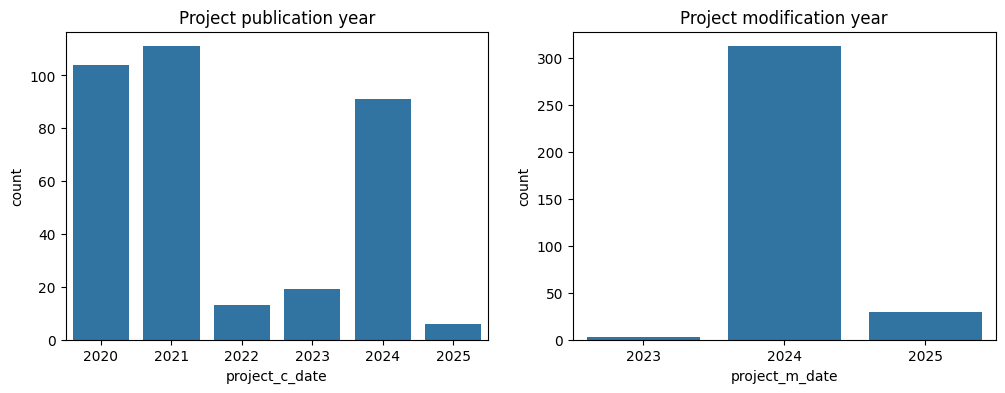

In [12]:
# Projects were published from 2020 to 2025, with spikes in 2020, 2021
# and 2024. Most data is updated to 2024.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=df\
  .groupby('project_name')['project_c_date'].first()
  .apply(lambda d: d.year)\
  .value_counts()\
  .sort_index(), ax=ax[0]
)
sns.barplot(data=df\
  .groupby('project_name')['project_m_date'].first()
  .apply(lambda d: d.year)\
  .value_counts()\
  .sort_index(), ax=ax[1]
)
ax[0].set_title('Project publication year')
ax[1].set_title('Project modification year')

!mkdir eda
fig.savefig('eda/project_date.png', bbox_inches='tight')

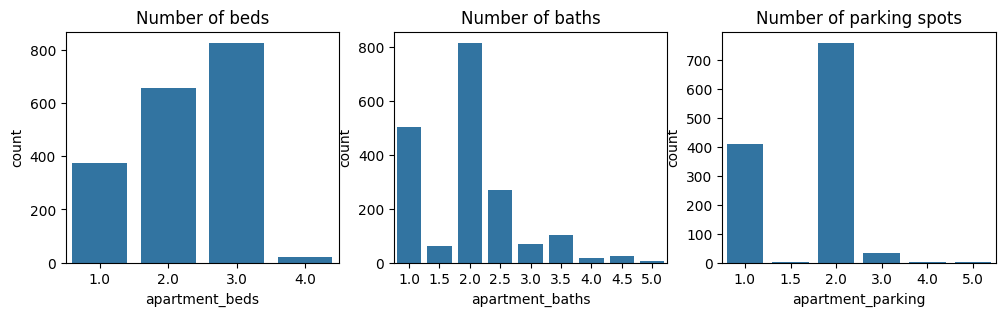

In [13]:
# Most apartments have 2-3 beds, 2 baths and 2 parking spots.
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df['apartment_beds'].value_counts(), ax=ax[0])
sns.barplot(data=df['apartment_baths'].value_counts(), ax=ax[1])
sns.barplot(data=df['apartment_parking'].value_counts(), ax=ax[2])

ax[0].set_title('Number of beds')
ax[1].set_title('Number of baths')
ax[2].set_title('Number of parking spots')
fig.savefig('eda/apartment_beds.png', bbox_inches='tight')

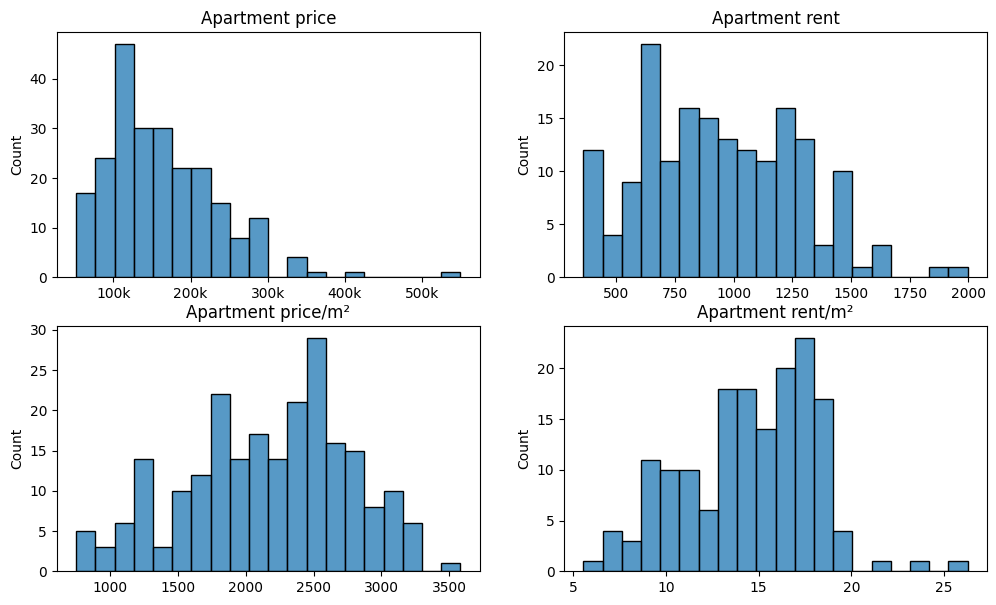

In [14]:
# Distributions of apartment price and rent.
fig, ax = plt.subplots(2, 2, figsize=(12, 7))

sns.histplot(data=df['apartment_price'], bins=20, ax=ax[0,0])
sns.histplot(data=df['apartment_rent'], bins=20, ax=ax[0,1])
sns.histplot(data=df['apartment_price_m2'], bins=20, ax=ax[1,0])
sns.histplot(data=df['apartment_rent_m2'], bins=20, ax=ax[1,1])

ax[0,0].xaxis.set_major_formatter(lambda x, pos: f'{x/1e3:.0f}k')
ax[0,0].set_title('Apartment price')
ax[0,1].set_title('Apartment rent')
ax[1,0].set_title('Apartment price/m²')
ax[1,1].set_title('Apartment rent/m²')
_ = [ax[i,j].set_xlabel('') for i in range(2) for j in range(2)]
fig.savefig('eda/apartment_price.png', bbox_inches='tight')

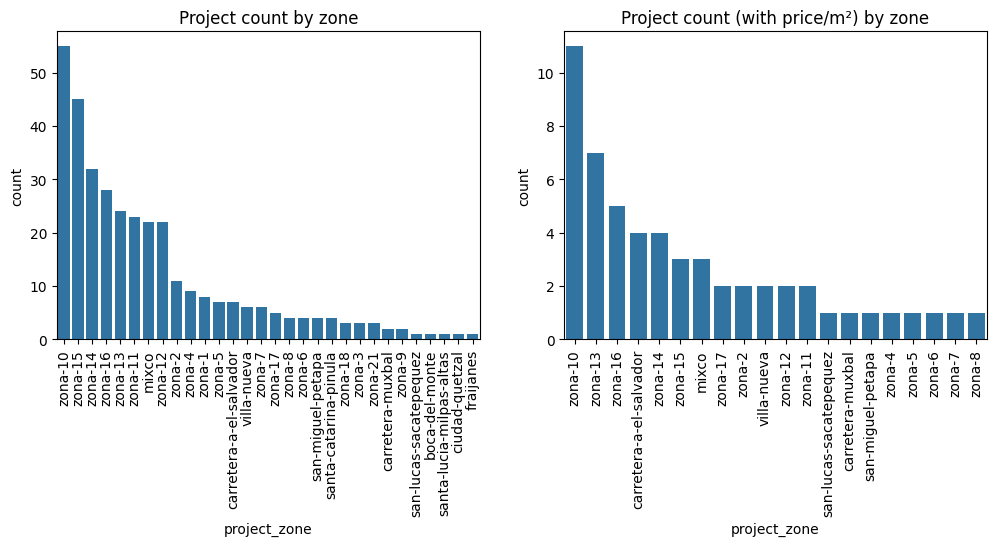

In [15]:
# There are 344 apartment projects in the dataset.
# Of these, only 55 projects have at least one apartment with info about
# footage and price. Only zones 10, 13, 14, 15, 16, as well as mixco and
# carretera al salvador have more that two projects with price/m² known.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

project_count_0 = df\
  .groupby('project_zone')['project_name']\
  .nunique()\
  .rename('count')\
  .sort_values(ascending=False)

project_count_1 = df[df['apartment_price_m2'].notna()]\
  .groupby('project_zone')['project_name']\
  .nunique()\
  .rename('count')\
  .sort_values(ascending=False)

sns.barplot(data=project_count_0, ax=ax[0])
sns.barplot(data=project_count_1, ax=ax[1])
ax[0].set_title('Project count by zone')
ax[1].set_title('Project count (with price/m²) by zone')
ax[0].tick_params(axis='x', labelrotation=90)
ax[1].tick_params(axis='x', labelrotation=90)
fig.savefig('eda/project_count_zone.png', bbox_inches='tight')

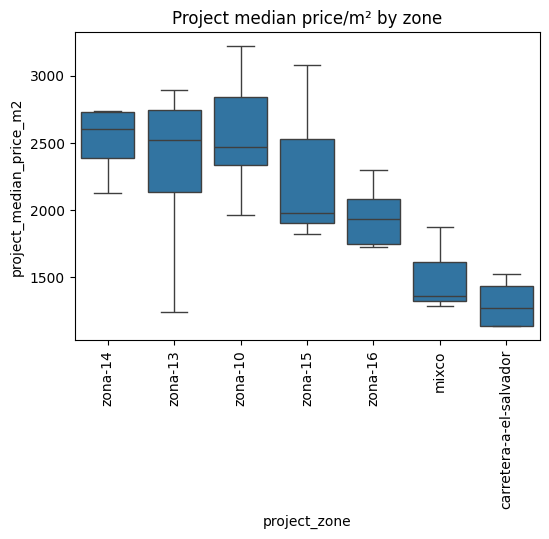

In [16]:
# The median price per squared meter was computed for each project in
# in the 7 zones mentioned above. These medians were then grouped by
# zone and presented in a boxplot. The zones with the highest median of
# medians are zones 14, 13 and 10, with values around $2.5k/m².
top_zones = project_count_1[project_count_1 > 2].index

project_median_price_m2 = df\
  .dropna(subset=['apartment_price_m2'])\
  .groupby('project_name')\
  .agg({
    'apartment_price_m2': 'median',
    'project_zone': 'first'
  })\
  .rename(columns={'apartment_price_m2': 'project_median_price_m2'})\
  .query('project_zone in @top_zones')

order = project_median_price_m2\
  .groupby('project_zone')['project_median_price_m2']\
  .median()\
  .sort_values(ascending=False)\
  .index

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax = sns.boxplot(data=project_median_price_m2,
  x='project_zone', y='project_median_price_m2', order=order)

ax.set_title('Project median price/m² by zone')
ax.tick_params(axis='x', labelrotation=90)
fig.savefig('eda/project_price_zone.png', bbox_inches='tight')

Estimated price/m² in zona-10: $2370/m²
Estimated price/m² in zona-13: $1988/m²
Estimated price/m² in zona-14: $2303/m²


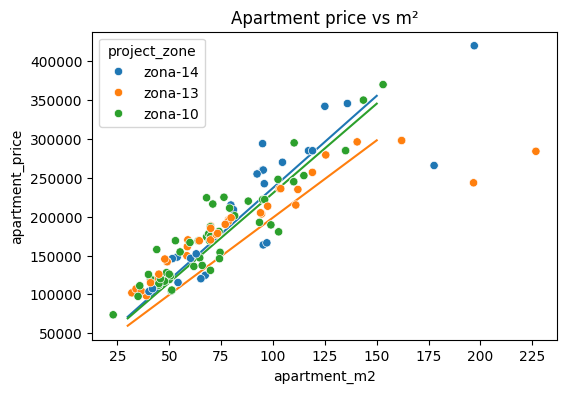

In [17]:
# We now plot each apartment in a price vs m² grid, colored by zone, for the
# first 3 zones in the previous plot. When fitting a linear model without
# intercept for each zone, zones 14, 13 and 10 exhibit lower price per
# meter squared. Zones 10 and 14 are around $2.3k/m², while zone 13 is at
# $2k/m². This is due to outliers: very large apartments with low price per m².
top_zones = ['zona-10','zona-13','zona-14']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax = sns.scatterplot(data=df[df['project_zone'].isin(top_zones)],
  x='apartment_m2', y='apartment_price', hue='project_zone')
ax.set_title('Apartment price vs m²')

for z in top_zones:
  df_reg = df\
    .dropna(subset=['apartment_price_m2'])\
    .query('project_zone == @z')
  reg = LinearRegression(fit_intercept=False)
  reg.fit(df_reg[['apartment_m2']], df_reg['apartment_price'])
  ax.plot([30,150], [30*reg.coef_,150*reg.coef_], zorder=-1)
  print(f'Estimated price/m² in {z}: ${reg.coef_[0]:.0f}/m²')

fig.savefig('eda/apartment_price_m2.png', bbox_inches='tight')

In [23]:
!zip -r eda.zip eda

  adding: eda/ (stored 0%)
  adding: eda/apartment_price_m2.png (deflated 4%)
  adding: eda/project_date.png (deflated 19%)
  adding: eda/project_count_zone.png (deflated 15%)
  adding: eda/apartment_price.png (deflated 21%)
  adding: eda/project_price_zone.png (deflated 14%)
  adding: eda/apartment_beds.png (deflated 16%)


# Maps

In [18]:
# We construct an interactive scatter plot showing the geolocations of
# every project in a map, along with a summary and some statistics
# of each project. Also, we show predicted prices for regions
# near these projects.

# Collect data and compute statistics for each project.
projects = df\
  .groupby('project_name')\
  .agg(
    lat=('project_lat', 'first'),
    lon=('project_lon', 'first'),
    zone=('project_zone', 'first'),
    c_date=('project_c_date', 'first'),
    m_date=('project_m_date', 'first'),
    m2_list=('apartment_m2', list),
    price_list=('apartment_price', list),
    price_m2_list=('apartment_price_m2', list),
    price_m2_median=('apartment_price_m2', 'median'),
  )\
  .reset_index()

# Construct a string to summarize a project's info. This will be shown
# when hovering over a data point in the map.
def project_str_info(r):
  cols = ['m2_list', 'price_list', 'price_m2_list']
  project = pd\
    .DataFrame(r[cols].to_dict())\
    .sort_values('m2_list')
  project.columns = ['m2', 'price', 'price_m2']

  m2_fmt = lambda x: f'{x:.0f}m²' if ~np.isnan(x) else ''
  price_fmt = lambda x: f'${x/1e3:.0f}k' if ~np.isnan(x) else ''
  price_m2_fmt = lambda x: f'${x/1e3:.2f}k' if ~np.isnan(x) else ''

  project['m2'] = project['m2'].apply(m2_fmt)
  project['price'] = project['price'].apply(price_fmt)
  project['price_m2'] = project['price_m2'].apply(price_m2_fmt)
  project.columns = ['Size', 'Price', 'Price/m²']

  info = project.to_markdown(index=False, tablefmt='github').split('\n')
  info[0] = re.sub('[^|]+', lambda x: f'<b>{x.group()}</b>', info[0])
  r['str_info'] = '<br>'.join(info)

  price_m2_median_fmt = lambda x: f'${x/1e3:.2f}k' if ~np.isnan(x) else 'NA'
  r['str_price_m2_median'] = price_m2_median_fmt(r['price_m2_median'])
  return r

projects = projects.apply(project_str_info, axis=1)

In [19]:
# Construct a grid of hexagons that cover Guatemala City, using
# the h3 library developed by Uber.
center_cell = h3.latlng_to_cell(14.59614, -90.51288, res=9)
cells = h3.grid_disk(center_cell, 100)
cells = pd.DataFrame(cells, columns=['hex_id'])

# Save the polygon border of each hexagon, as well as the
# latitude and longitude of their centers.
cells['geometry'] = cells['hex_id']\
  .apply(h3.cell_to_boundary)\
  .apply(lambda r: [ri[::-1] for ri in r])\
  .apply(Polygon)
cells = gpd.GeoDataFrame(cells, crs='EPSG:4326')

cells[['lat','lon']] = cells\
  .apply(lambda r: h3.cell_to_latlng(r['hex_id']),
    axis=1, result_type='expand')

# Project latitudes and longitudes to mercator.
cell_points = gpd.points_from_xy(
    cells['lon'], cells['lat'], crs='EPSG:4326')\
  .to_crs('EPSG:3857')
cells['x'], cells['y'] = cell_points.x, cell_points.y

project_points = gpd.points_from_xy(
    projects['lon'], projects['lat'], crs='EPSG:4326')\
  .to_crs('EPSG:3857')
projects['x'], projects['y'] = project_points.x, project_points.y

# Train a radial nearest neighbors regressor based on the
# projects' price/m², and predict this value for neighboring hex tiles.
# Tiles without neighbors in the specified radius (1km) are dropped.
reg = RadiusNeighborsRegressor(radius=1000, weights='distance')
reg.fit(projects.dropna(subset=['price_m2_median'])[['x','y']],
        projects.dropna(subset=['price_m2_median'])['price_m2_median'])
cells['price_m2_median'] = reg.predict(cells[['x','y']])

cells = cells.dropna(subset=['price_m2_median'])
cells = cells.set_index('hex_id')

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_regression.py:508: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


In [20]:
# Construct a scatter map of the projects, colored by
# median project price/m².
fig_projects = px.scatter_map(projects,
  lat='lat', lon='lon', color='price_m2_median',
  color_continuous_scale='viridis',
  labels={'price_m2_median':'Price/m²'},
  text='project_name',
  custom_data=['zone', 'c_date', 'm_date', 'str_price_m2_median', 'str_info'],
  zoom=10.5, map_style='carto-positron',
  center={'lat': 14.59614, 'lon': -90.51288}
)
fig_projects.update_traces(
  hovertemplate = \
    ' <b>Project:</b> %{text}<br>' \
    ' <b>Location:</b> %{customdata[0]}<br>' \
    ' <b>Published:</b> %{customdata[1]}<br>' \
    ' <b>Modified:</b> %{customdata[2]}<br>' \
    ' <b>Median price/m²:</b> %{customdata[3]}<br><br>' \
    '<span style="font-family:monospace">%{customdata[4]}</span>' \
    '<extra></extra>'
)

# Construct a choropleth map of the hex tiles, colored by
# predicted median project price/m².
fig_hex = px.choropleth_map(cells,
  geojson=cells.geometry,
  locations=cells.index,
  color='price_m2_median', opacity=0.3,
  color_continuous_scale='viridis'
)
fig_hex.update_traces(hoverinfo='skip', hovertemplate=None)
fig_projects.add_trace(fig_hex.data[0])

# Add zone borders, buttons and cosmetics.
map = dict(layers=[
  dict(source=zone_borders.__geo_interface__,
    type='line', below='traces', color='#2a3f5f')
])
buttons = [
  dict(label='Show Predicted Price/m²', args=[{'visible': [True,True]}]),
  dict(label='Hide Predicted Price/m²', args=[{'visible': [True,False]}]),
]
fig_projects.update_layout(
  title='<b>Apartment Projects in Guatemala City</b>',
  margin=dict(r=5,l=5,b=5), map=map,
  updatemenus=[
    dict(buttons=buttons, pad=dict(r=5,t=5,l=5,b=5),
    xanchor='right', x=1, yanchor='top', y=1)
  ]
)

fig_projects.show()
fig_projects.write_html('projects_map.html')